# Example 03 - Official WidebandSig53 Dataset
This notebook walks through how to use `torchsig` to generate the Official WidebandSig53 Dataset.

-------------------------------------------

### Import Libraries

In [1]:
from torchsig.utils.visualize import MaskClassVisualizer, mask_class_to_outline, complex_spectrogram_to_magnitude
from torchsig.transforms.target_transforms.target_transforms import DescToMaskClass
from torchsig.transforms.expert_feature.eft import Spectrogram
from torchsig.transforms.signal_processing.sp import Normalize
from torchsig.datasets.wideband_sig53 import WidebandSig53
from torchsig.transforms.transforms import Compose
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

/home/gvanhoy/.virtual_envs/python38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----------------------------
## Generate the Wideband Sig53 Dataset
To generate the WidebandSig53 dataset, several parameters are given to the imported `WidebandSig53` class. These paramters are:
- `root` ~ A string to specify the root directory of where to generate and/or read an existing WidebandSig53 dataset
- `train` ~ A boolean to specify if the WidebandSig53 dataset should be the training (True) or validation (False) sets
- `impaired` ~ A boolean to specify if the WidebandSig53 dataset should be the clean version or the impaired version
- `transform` ~ Optionally, pass in any data transforms here if the dataset will be used in an ML training pipeline. Note: these transforms are not called during the dataset generation. The static saved dataset will always be in IQ format. The transform is only called when retrieving data examples.
- `target_transform` ~ Optionally, pass in any target transforms here if the dataset will be used in an ML training pipeline. Note: these target transforms are not called during the dataset generation. The static saved dataset will always be saved as tuples in the LMDB dataset. The target transform is only called when retrieving data examples.
- `regenerate` ~ Optionally, pass in a boolean to specify if the dataset should be regenerated, even if an available one is detected
- `use_signal_data` ~ Optionally, pass in a boolean to specify if the annotations should be interpreted as `SignalData` objects as LMDB data is read. This is necessary when using the TorchSig pipeline; however, setting the value to False will simply return the annotations as a list of tuples as it is saved in the LMDB static data
- `gen_batch_size` ~ Optionally, pass in an integer to specify how many processes to spin up during the generation process. Note: this defaults to a single process and is recommended to remain a single process when generation occurs on the GPU.
- `use_gpu` ~ Optionally, pass in a boolean to specify if the data generation should occur on the GPU. Deafult behavior is True. Due to speed differences, it is highly recommended that generation occurs on the GPU. On a single V100, the WidebandSig53 dataset may take up to two days to complete its generation. Without a GPU, generation can take much longer.

A combination of the `train` and the `impaired` booleans determines which of the four (4) distinct WidebandSig53 datasets will be instantiated:
- `train=True` & `impaired=False` = Clean training set of 250k examples
- `train=True` & `impaired=True` = Impaired training set of 250k examples
- `train=False` & `impaired=False` = Clean validation set of 25k examples
- `train=False` & `impaired=True` = Impaired validation set of 25k examples

The final option of the impaired validation set is the dataset to be used when reporting any results with the official WidebandSig53 dataset.

In [2]:
# Specify WidebandSig53 Options
root = 'wideband_sig53/'
train = False
impaired = False
fft_size = 512
num_classes = 53

transform = Compose([
    Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode='complex'),
    Normalize(norm=np.inf, flatten=True),
])

target_transform = Compose([
    DescToMaskClass(num_classes=num_classes, width=fft_size, height=fft_size),
])

# Instantiate the WidebandSig53 Dataset
wideband_sig53 = WidebandSig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    regenerate=False,
    use_signal_data=True,
    gen_batch_size=1,
    use_gpu=True,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_sig53))
data, label = wideband_sig53[idx]
print("Dataset length: {}".format(len(wideband_sig53)))
print("Data shape: {}".format(data.shape))
print("Label shape: {}".format(label.shape))

100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


Dataset length: 25
Data shape: (2, 512, 512)
Label shape: (53, 512, 512)


### Plot Subset to Verify
The `MaskClassVisualizer` can be passed a `Dataloader` and plot visualizations of the dataset. The `batch_size` of the `DataLoader` determines how many examples to plot for each iteration over the visualizer. Note that the dataset itself can be indexed and plotted sequentially using any familiar python plotting tools as an alternative plotting method to using the `spdata` `Visualizer` as shown below.

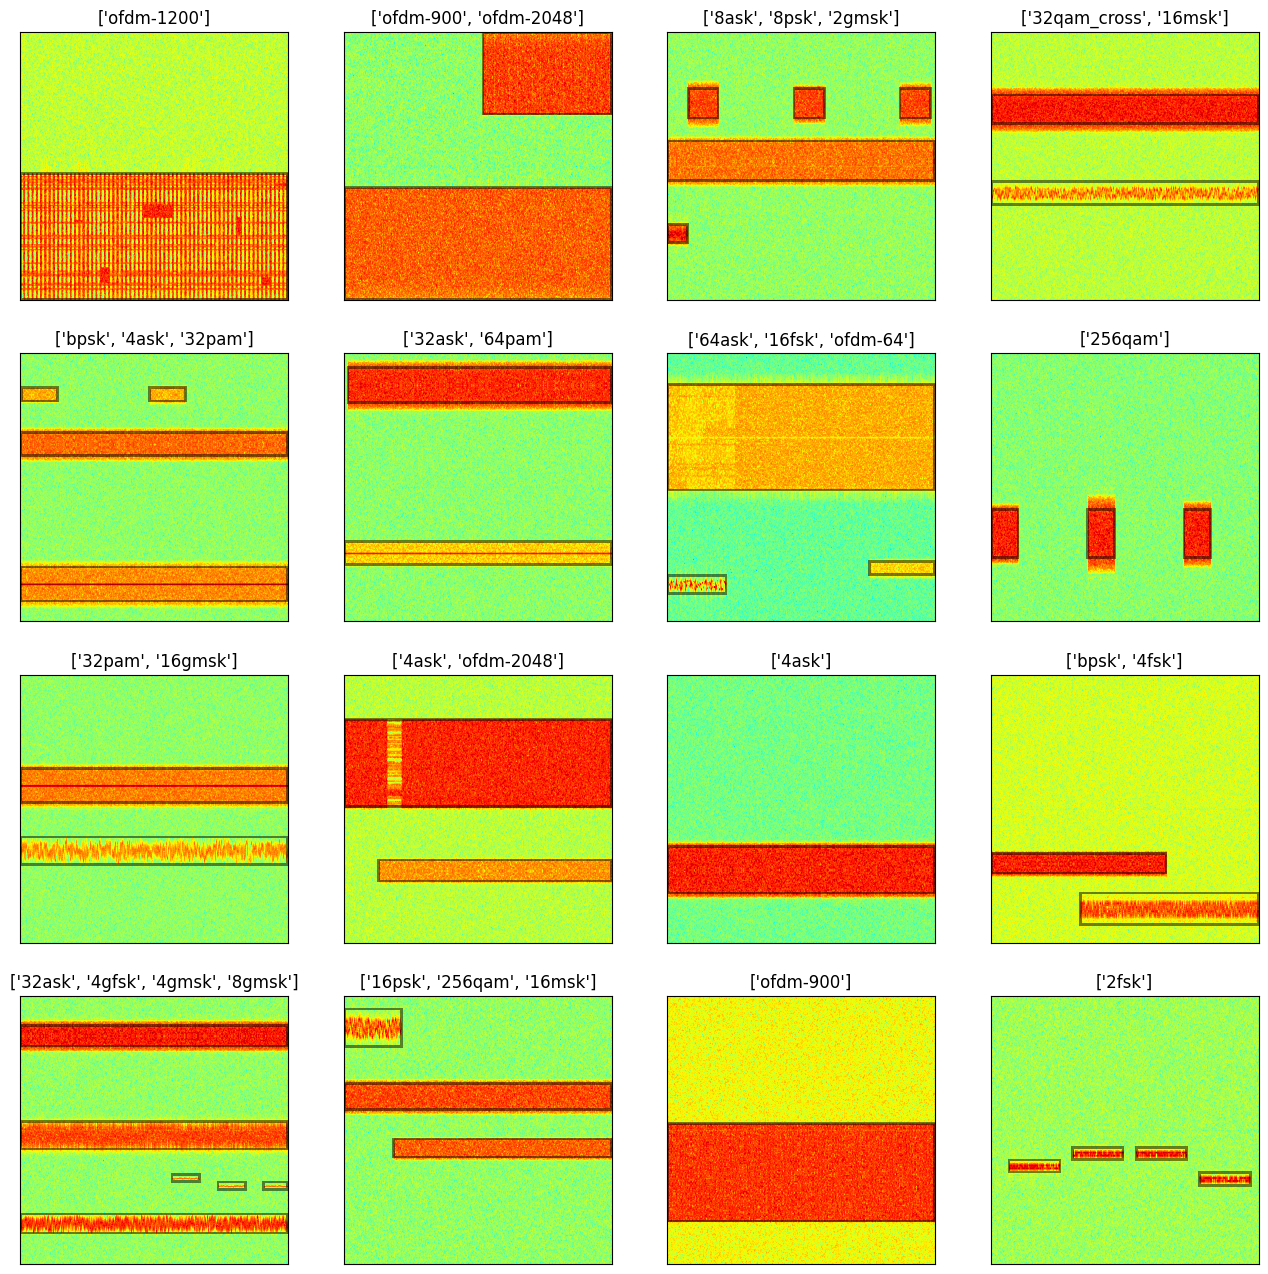

In [3]:
data_loader = DataLoader(
    dataset=wideband_sig53,
    batch_size=16,
    shuffle=True,
)

visualizer = MaskClassVisualizer(
    data_loader=data_loader,
    visualize_transform=complex_spectrogram_to_magnitude,
    visualize_target_transform=mask_class_to_outline,
    class_list=wideband_sig53.modulation_list,
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 16)
    plt.show()
    break

----
### Analyze Dataset
The dataset can also be analyzed at the macro level for details such as the distribution of classes and number of signals per sample. The below analysis reads information directly from the non-target transformed tuple annotations. Since this is different than the above dataset instantiation, the dataset is re-instantiated for analysis.

In [4]:
# Re-instantiate the WidebandSig53 Dataset without a target transform and without using the RFData objects
wideband_sig53 = WidebandSig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=transform,
    target_transform=None,
)

# Loop through the dataset recording classes and SNRs
class_counter_dict = {
    class_name: 0 for class_name in list(wideband_sig53.modulation_list)
}
num_signals_per_sample = []

for idx in tqdm(range(len(wideband_sig53))):
    data, annotation = wideband_sig53[idx]
    num_signals_per_sample.append(len(annotation))
    for signal_annotation in annotation:
        class_counter_dict[signal_annotation.class_name] += 1

Existing data found, skipping data generation


100%|██████████| 25/25 [00:00<00:00, 122.60it/s]


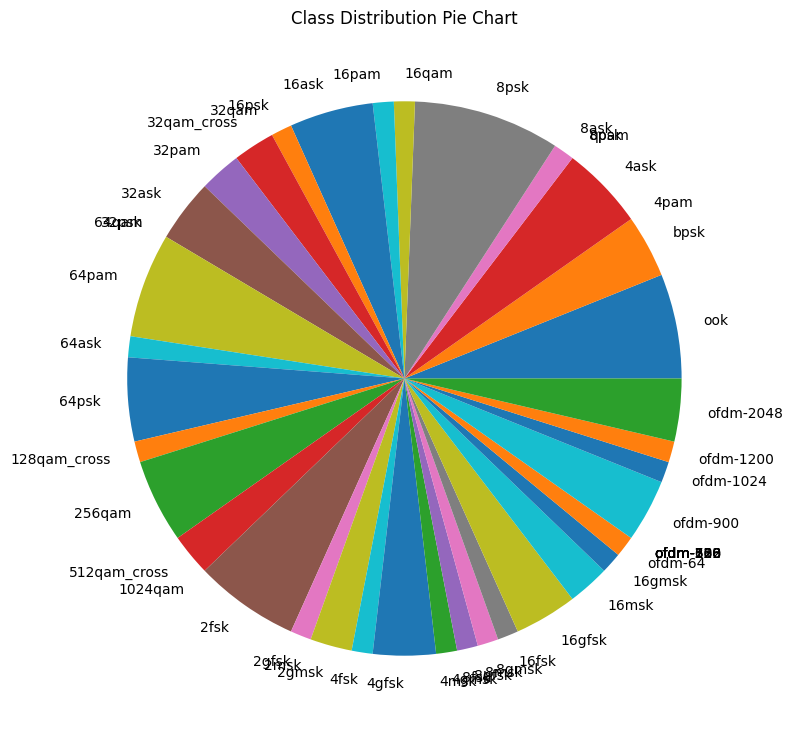

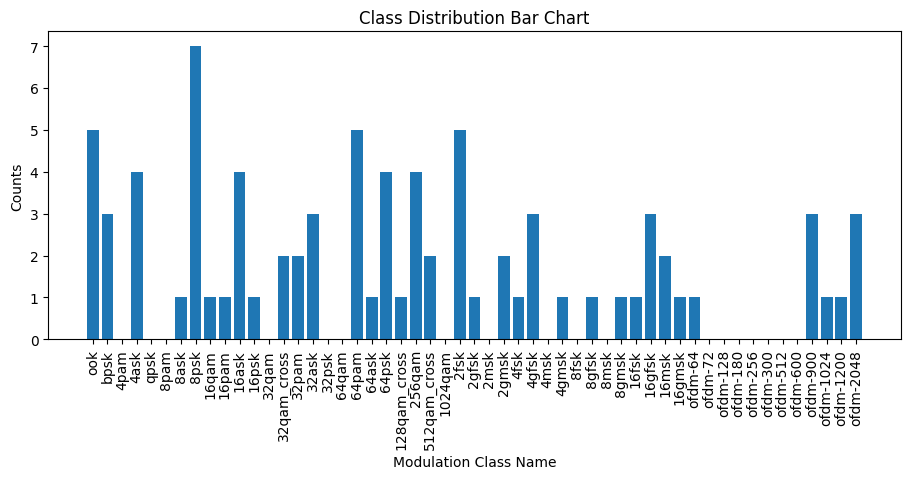

In [5]:
# Plot the distribution of classes
class_names = list(class_counter_dict.keys())
num_classes = list(class_counter_dict.values())

plt.figure(figsize=(9,9))
plt.pie(num_classes, labels=class_names)
plt.title("Class Distribution Pie Chart")
plt.show()

plt.figure(figsize=(11,4))
plt.bar(class_names, num_classes)
plt.xticks(rotation=90)
plt.title("Class Distribution Bar Chart")
plt.xlabel("Modulation Class Name")
plt.ylabel("Counts")
plt.show()

The above distribution of classes shows all OFDM signals appearing less frequently than the remaining modulations. This makes sense because OFDM signals are drawn from a random distribution of bandwidths that are inherently larger than the remaining signals, meaning fewer OFDM signals can fit into a wideband spectrum without overlapping. Additionally, the random bursty probability and durations of OFDM signals makes it less likely to occupy a wideband capture with many short-time bursts, while the remaining modulations experience this behavior at a higher probility.

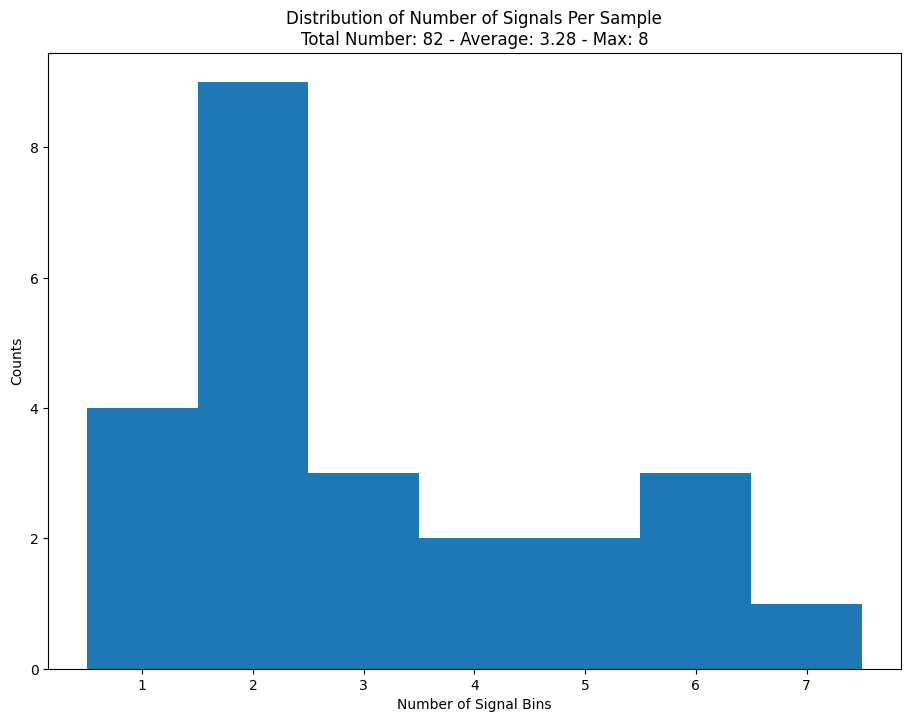

In [6]:
# Plot the distribution of number of signals per sample
plt.figure(figsize=(11,8))
plt.hist(x=num_signals_per_sample, bins=np.arange(1,max(num_signals_per_sample)+1)-0.5)
plt.title("Distribution of Number of Signals Per Sample\nTotal Number: {} - Average: {} - Max: {}".format(
    sum(num_signals_per_sample),
    np.mean(np.asarray(num_signals_per_sample)),
    max(num_signals_per_sample),
))
plt.xlabel("Number of Signal Bins")
plt.ylabel("Counts")
plt.show()

The above distribution of the number of signals per sample shows the most commonly seen sample has two signals present. The average is slightly around 4 signals per sample and the max is 26.

In [7]:
# For additional analysis, reinstantiate the dataset without a target transform, such that the RFDescriptions can be read
wideband_sig53 = WidebandSig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=None,
    target_transform=None,
)

num_samples = len(wideband_sig53)
snrs = []
bandwidths = []
durations = []
for idx in tqdm(range(num_samples)):
    label = wideband_sig53[idx][1]
    for rf_desc in label:
        snrs.append(rf_desc.snr)
        bandwidths.append(rf_desc.bandwidth)
        durations.append(rf_desc.duration)

Existing data found, skipping data generation


100%|██████████| 25/25 [00:00<00:00, 1204.42it/s]


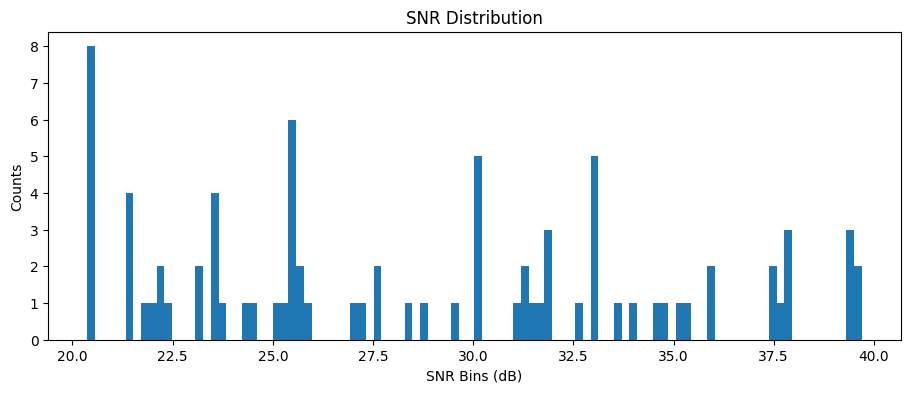

In [8]:
# Plot the distribution of SNR values
plt.figure(figsize=(11,4))
plt.hist(x=snrs, bins=100)
plt.title("SNR Distribution")
plt.xlabel("SNR Bins (dB)")
plt.ylabel("Counts")
plt.show()

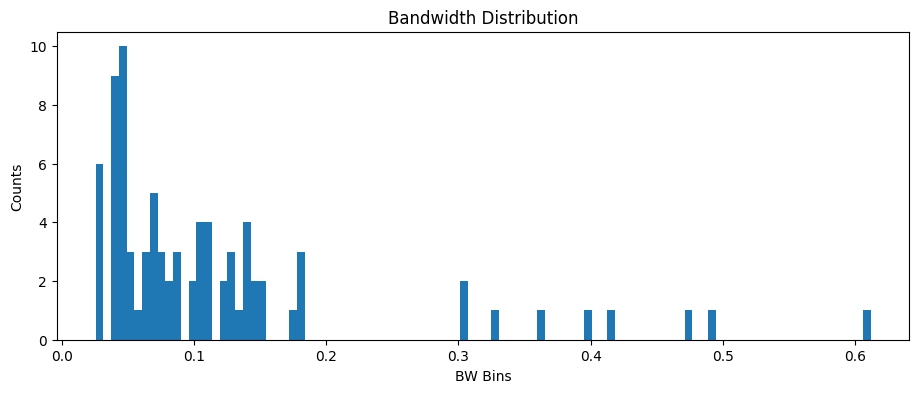

In [9]:
# Plot the distribution of bandwidth values
plt.figure(figsize=(11,4))
plt.hist(x=bandwidths, bins=100)
plt.title("Bandwidth Distribution")
plt.xlabel("BW Bins")
plt.ylabel("Counts")
plt.show()

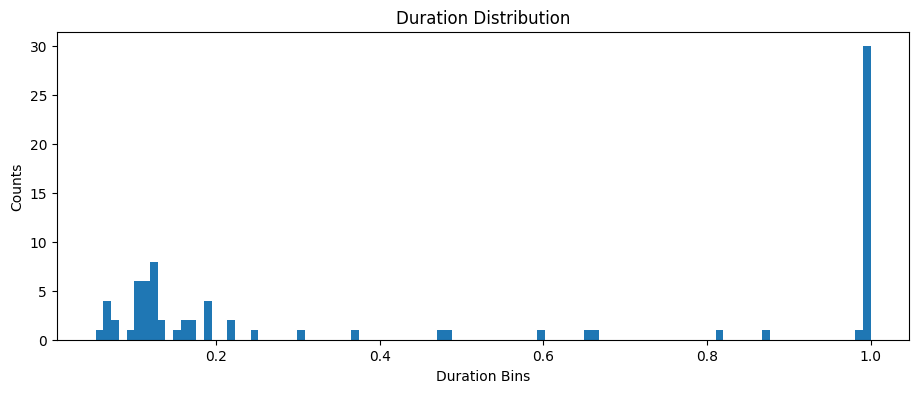

In [10]:
# Plot the distribution of bandwidth values
plt.figure(figsize=(11,4))
plt.hist(x=durations, bins=100)
plt.title("Duration Distribution")
plt.xlabel("Duration Bins")
plt.ylabel("Counts")
plt.show()